In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [4]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [5]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [6]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [7]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [8]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [9]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [10]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [11]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

In [12]:
data_name_list = ['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread', 'credit_spread', 'safe_haven_return', 'EMA_diff',
                  'USD/KRW', 'KR_CDS_spread']
whole_data_df = pd.DataFrame([
        put_call_5d_sum['put/call ratio'],
        kospi_index_df['kospi_deviation'],
        vkospi_df['vkospi_deviance'],
        junk_bond_spread_df['junkbond_spread'],
        junk_bond_spread_df['credit_spread'],
        safe_haven_demand_df['safe_haven_return'],
        mcclellan_df['EMA_diff'],
        tidy_data['원/달러(종가)'],
        tidy_data['한국 CDS Spread'],
    ], index = data_name_list)

whole_data_df = whole_data_df.T

In [13]:
#### PCA 결과

def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

mean_values = standardized_df.T.mean().T * 50 + 50

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

# 그냥 지수
normalized_mean_values = mean_values
# 100으로 변환 되도록 바꿈
normalized_mean_values = normalize_series(mean_values) *100

In [16]:
## PCA Things

# 전체 기간
pca_feature_df = standardized_df.dropna()
n_th_pc = 1
n_principal_component = 9
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                                                'PC6', 'PC7', 'PC8', 'PC9'])

principalDf = -principalDf.iloc[:, n_th_pc-1]
principalDf.index = pca_feature_df.index
principal_vectors = - pca.components_


print(principal_vectors[0, :])
print(standardized_df.columns)

[-0.02253051  0.43574972  0.29090684 -0.12903808  0.28268422  0.3596675
  0.30567102  0.44008241  0.46038958]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


#ㅁ

PLS Index:
[-0.39039728 -0.33066502 -0.04031533  0.15656572 -0.06481715]
[1.29447053 1.24178673 1.45746266 1.43134179 1.38901891]

PLS Vector:
[ 0.36118451 -0.18259794  0.24238506  0.72860726  0.07672553  0.26939553
  0.26108466 -0.12780646  0.28917855]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


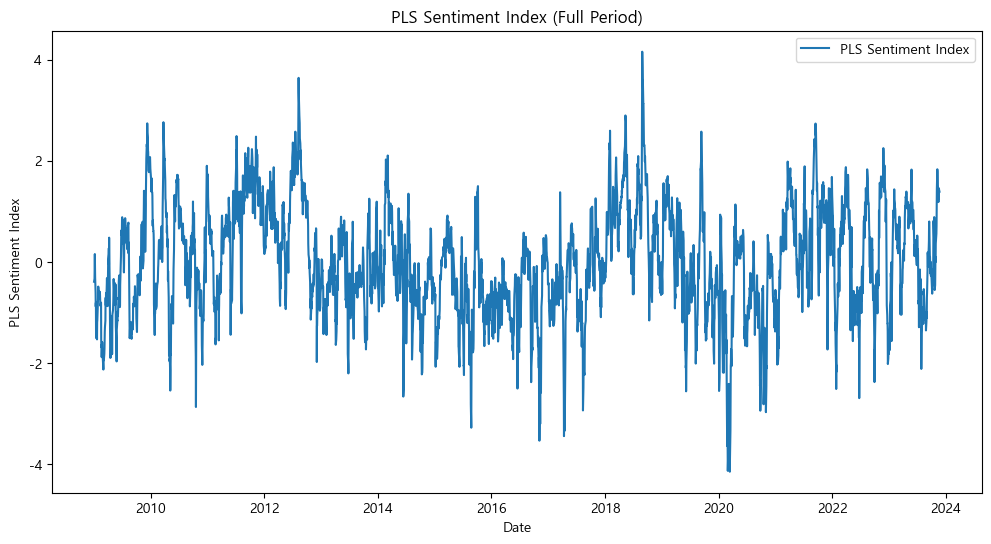

In [17]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import datetime as dt

# 예제 데이터 준비
pls_feature_df = standardized_df.dropna()
target = kospi_index_df['코스피 지수'].copy()

# 날짜 및 데이터 필터링
dates = pls_feature_df.index
features = pls_feature_df

n_day = 125

# Rolling mean을 계산하고 NaN 값 처리
# target = target.rolling(window=n_day, min_periods=1).mean()
target = target.pct_change(periods=n_day)
target = target.shift(-n_day)

# 시작 날짜 필터링
start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

end_date_str = '2025-01-01'
end_date_dt = dt.datetime.strptime(end_date_str, '%Y-%m-%d')

features = features.loc[features.index > start_date_dt]
target = target.loc[target.index > start_date_dt]

features = features.loc[features.index < end_date_dt]
target = target.loc[target.index < end_date_dt]

# features와 target의 공통 날짜 필터링
target = target.dropna()
common_dates = features.index.intersection(target.index)
features = features.loc[common_dates]
target = target.loc[common_dates]


# PLS 모델 생성 및 학습
pls = PLSRegression(n_components=1)
pls.fit(features.values, target.values.reshape(-1, 1))

# PLS 인덱스 생성
pls_index = pls.transform(features.values).flatten()

# PLS 벡터 저장
pls_vector = pls.x_weights_[:, 0]

# 결과 출력
print("PLS Index:")
print(pls_index[:5])
print(pls_index[-5:])

print("\nPLS Vector:")
print(pls_vector)

print(standardized_df.columns)

# PLS 인덱스를 시리즈로 변환하여 인덱스 설정
pls_index = pd.Series(pls_index, index=features.index)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pls_index, label='PLS Sentiment Index')
plt.xlabel('Date')
plt.ylabel('PLS Sentiment Index')
plt.title('PLS Sentiment Index (Full Period)')
plt.legend()
plt.show()


<Axes: xlabel='0', ylabel='PC1'>

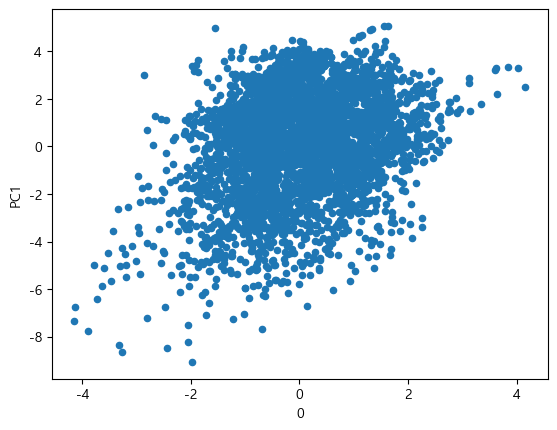

In [20]:
plot_df.plot.scatter(x=0, y='PC1')

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [25]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     15.64
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           7.80e-05
Time:                        14:30:06   Log-Likelihood:                -10569.
No. Observations:                3551   AIC:                         2.114e+04
Df Residuals:                    3549   BIC:                         2.115e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8823      0.948     -3.040      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [27]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.709
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0301
Time:                        14:30:23   Log-Likelihood:                -10570.
No. Observations:                3528   AIC:                         2.114e+04
Df Residuals:                    3526   BIC:                         2.116e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4513      1.060      2.313      0.0

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [28]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = -60
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.576
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.209
Time:                        14:30:43   Log-Likelihood:                -12137.
No. Observations:                3551   AIC:                         2.428e+04
Df Residuals:                    3549   BIC:                         2.429e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1776      1.930      1.646      0.1

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [30]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7.956
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00482
Time:                        14:31:00   Log-Likelihood:                -11873.
No. Observations:                3491   AIC:                         2.375e+04
Df Residuals:                    3489   BIC:                         2.376e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1921      2.123      2.916      0.0

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [31]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                    0.8176
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.366
Time:                        14:31:23   Log-Likelihood:                -13520.
No. Observations:                3551   AIC:                         2.704e+04
Df Residuals:                    3549   BIC:                         2.706e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7148      3.222      1.463      0.1

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [32]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     9.445
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00213
Time:                        14:31:42   Log-Likelihood:                -12908.
No. Observations:                3425   AIC:                         2.582e+04
Df Residuals:                    3423   BIC:                         2.583e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1755      4.039      3.015      0.0

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [33]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.236
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.135
Time:                        14:32:23   Log-Likelihood:                -15203.
No. Observations:                3551   AIC:                         3.041e+04
Df Residuals:                    3549   BIC:                         3.042e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2298      3.874     -0.317      0.7

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [34]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     8.071
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00453
Time:                        14:32:37   Log-Likelihood:                -13830.
No. Observations:                3300   AIC:                         2.766e+04
Df Residuals:                    3298   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.4961      7.981      2.693      0.0

# 21년 이후

PLS Index:
[-0.11829367  0.03044137  0.38648091  0.73855217  0.42466069]
[-1.05892732 -0.88408376 -1.05170008 -0.55497961  0.07011841]

PLS Vector:
[ 0.48355669 -0.04081431  0.20190454  0.60648843  0.14589303  0.23011114
  0.30540709  0.1176367   0.41781055]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


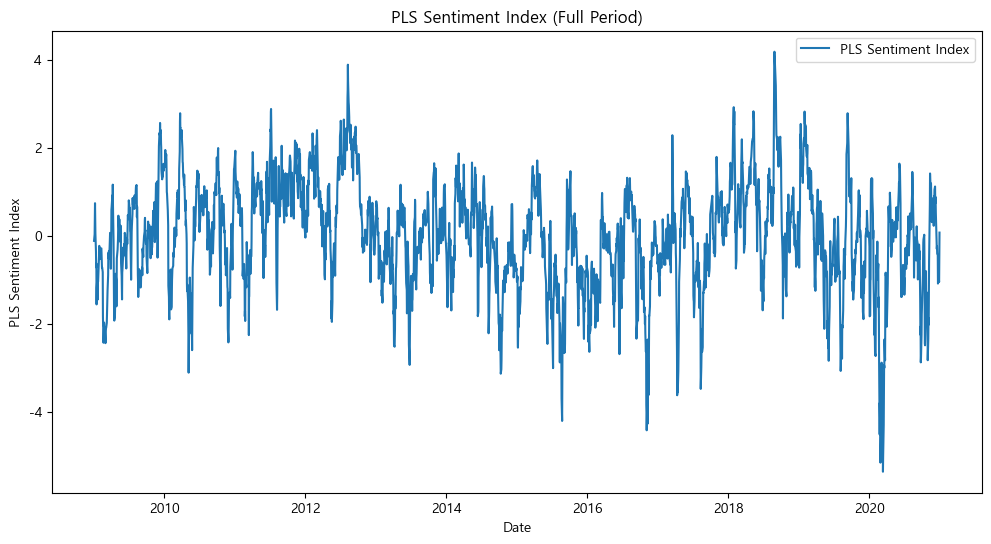

In [48]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import datetime as dt

# 예제 데이터 준비
pls_feature_df = standardized_df.dropna()
target = kospi_index_df['코스피 지수'].copy()

# 날짜 및 데이터 필터링
dates = pls_feature_df.index
features = pls_feature_df

n_day = 125

# Rolling mean을 계산하고 NaN 값 처리
# target = target.rolling(window=n_day, min_periods=1).mean()
target = target.pct_change(periods=n_day)
target = target.shift(-n_day)

# 시작 날짜 필터링
start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

end_date_str = '2020-12-31'
end_date_dt = dt.datetime.strptime(end_date_str, '%Y-%m-%d')

features = features.loc[features.index > start_date_dt]
target = target.loc[target.index > start_date_dt]

features = features.loc[features.index < end_date_dt]
target = target.loc[target.index < end_date_dt]

# features와 target의 공통 날짜 필터링
target = target.dropna()
common_dates = features.index.intersection(target.index)
features = features.loc[common_dates]
target = target.loc[common_dates]


# PLS 모델 생성 및 학습
pls = PLSRegression(n_components=1)
pls.fit(features.values, target.values.reshape(-1, 1))

# PLS 인덱스 생성
pls_index = pls.transform(features.values).flatten()

# PLS 벡터 저장
pls_vector = pls.x_weights_[:, 0]

# 결과 출력
print("PLS Index:")
print(pls_index[:5])
print(pls_index[-5:])

print("\nPLS Vector:")
print(pls_vector)

print(standardized_df.columns)

# PLS 인덱스를 시리즈로 변환하여 인덱스 설정
pls_index = pd.Series(pls_index, index=features.index)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pls_index, label='PLS Sentiment Index')
plt.xlabel('Date')
plt.ylabel('PLS Sentiment Index')
plt.title('PLS Sentiment Index (Full Period)')
plt.legend()
plt.show()


<Axes: xlabel='0', ylabel='PC1'>

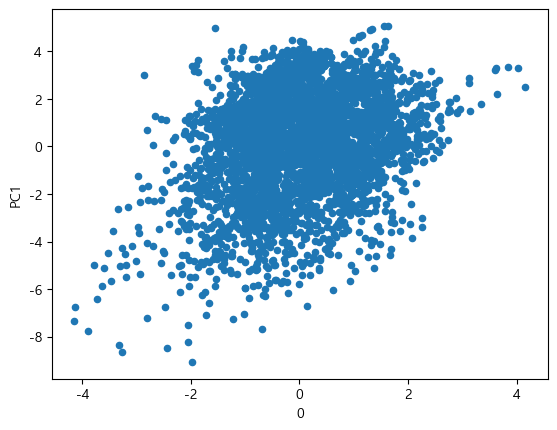

In [49]:
plot_df.plot.scatter(x=0, y='PC1')

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [50]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     26.36
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.53e-07
Time:                        15:02:40   Log-Likelihood:                -2372.6
No. Observations:                 837   AIC:                             4749.
Df Residuals:                     835   BIC:                             4759.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6800      1.978     -4.388      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [51]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                    0.8542
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.356
Time:                        15:02:44   Log-Likelihood:                -2391.5
No. Observations:                 814   AIC:                             4787.
Df Residuals:                     812   BIC:                             4796.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3164      2.002      0.658      0.5

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [52]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = -60
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.790
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.181
Time:                        15:02:48   Log-Likelihood:                -2962.9
No. Observations:                 837   AIC:                             5930.
Df Residuals:                     835   BIC:                             5939.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2710      4.313     -0.758      0.4

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [53]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = 0
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.4163
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.519
Time:                        15:02:50   Log-Likelihood:                -2484.3
No. Observations:                 777   AIC:                             4973.
Df Residuals:                     775   BIC:                             4982.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9754      1.971     -1.002      0.3

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [54]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.799
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0288
Time:                        15:02:55   Log-Likelihood:                -3419.3
No. Observations:                 837   AIC:                             6843.
Df Residuals:                     835   BIC:                             6852.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1934      7.711     -1.192      0.2

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [55]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.374
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.124
Time:                        15:03:07   Log-Likelihood:                -2593.9
No. Observations:                 711   AIC:                             5192.
Df Residuals:                     709   BIC:                             5201.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1194      3.726      0.032      0.9

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [56]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.421
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0358
Time:                        15:03:39   Log-Likelihood:                -3939.6
No. Observations:                 837   AIC:                             7883.
Df Residuals:                     835   BIC:                             7893.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.8641     11.126     -0.976      0.3

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [57]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 15 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.330
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0213
Time:                        15:03:40   Log-Likelihood:                -2333.7
No. Observations:                 586   AIC:                             4671.
Df Residuals:                     584   BIC:                             4680.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5422      5.057     -0.107      0.9